# PIK3CA: Effects of Mutation on IRS1

<b> Standard imports for playing with and plotting data frames. </b>

In [5]:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
import re
import statsmodels.stats.multitest

<b> Import CPTAC data </b>

In [6]:
import CPTAC

Loading CPTAC data:
Loading Dictionary...
Loading Clinical Data...
Loading Proteomics Data...
Loading Transcriptomics Data...
Loading CNA Data...
Loading Phosphoproteomics Data...
Loading Somatic Mutation Data...

 ******PLEASE READ******
CPTAC is a community resource project and data are made available
rapidly after generation for community research use. The embargo
allows exploring and utilizing the data, but the data may not be in a
publication until July 1, 2019. Please see
https://proteomics.cancer.gov/data-portal/about/data-use-agreement or
enter CPTAC.embargo() to open the webpage for more details.


In [7]:
somatic_mutations = CPTAC.get_somatic()
#print(somatic_mutations)


proteomics = CPTAC.get_proteomics()
print(proteomics)


phos = CPTAC.get_phosphoproteomics()
print(phos)

idx     A1BG     A2M    A2ML1  A4GALT      AAAS    AACS    AADAT    AAED1  \
S001 -1.1800 -0.8630 -0.80200  0.2220  0.256000  0.6650  1.28000 -0.33900   
S002 -0.6850 -1.0700 -0.68400  0.9840  0.135000  0.3340  1.30000  0.13900   
S003 -0.5280 -1.3200  0.43500     NaN -0.240000  1.0400 -0.02130 -0.04790   
S004  2.3500  2.8200 -1.47000     NaN  0.154000  0.0332  0.51300  0.67400   
S005 -1.6700 -1.1900 -0.44300  0.2430 -0.099300  0.7570  0.74000 -0.92900   
S006 -0.3740 -0.0206 -0.53700  0.3110  0.375000  0.0131 -1.10000      NaN   
S007 -1.0800 -0.7080 -0.12600 -0.4260 -0.114000 -0.1110  0.89500  1.26000   
S008 -1.3200 -0.7080 -0.80800 -0.0709  0.138000  0.6560 -0.28000 -0.12800   
S009 -0.4670  0.3700 -0.33900     NaN  0.434000  0.0358 -0.17500  0.18100   
S010 -1.1200 -1.3100  0.91200  0.4180 -0.076800  0.8460 -0.12100      NaN   
S011 -0.7160 -0.8850  2.82000 -0.3430  0.147000  0.4450 -0.05650 -0.83800   
S012 -0.2320 -0.0910  0.61800  1.6300 -0.250000  1.3300 -1.72000 -0.88900   

# PI3KCA mutation and IRS1 proteome abundance 

<b> Take out the control </b>

In [8]:
proteomics = proteomics[:100]

### Perform a t-test with mutated and non-mutated protein levels

In [9]:
protList = ['IRS1']
pcutoff = 0.05 / len(protList)
gene = 'PIK3CA'

sigResults = [];
for protein in protList: 
    if protein in proteomics.columns:
        cross = CPTAC.compare_mutations(proteomics, protein, gene)
        cross = cross[["Mutation", protein]].dropna(axis=0)
        mutated = cross.loc[cross["Mutation"] == "Missense_Mutation"]
        wt = cross.loc[cross["Mutation"] == "Wildtype"]
        ttest = scipy.stats.ttest_ind(mutated[protein], wt[protein])
        if(ttest[1] <= pcutoff):
            sigResults.append(protein)
            print("Test for " + protein + ": ")
            print(ttest) 
        else:
            print("Unsignificant result for " + protein + ": ")
            print(ttest) 
            

Unsignificant result for IRS1: 
Ttest_indResult(statistic=-1.0601355321350932, pvalue=0.29177084447657115)


 ### We can now plot the data 

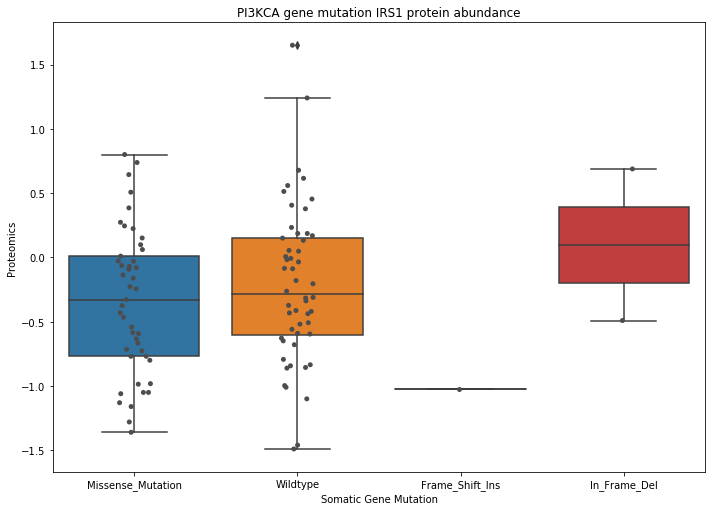

In [10]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
somatic_boxplot = sns.boxplot(data=cross, x="Mutation",y='IRS1', ax = ax)
somatic_boxplot.set_title("PI3KCA gene mutation IRS1 protein abundance")
somatic_boxplot = sns.stripplot(data=cross, x="Mutation", y='IRS1',jitter=True, color=".3")
somatic_boxplot.set(xlabel="Somatic Gene Mutation",ylabel="Proteomics")
plt.show()

# PI3KCA mutation and IRS1 phosphoproteome abundance 

In [11]:
sites = phos.columns
p_values = []
site_names = []
phosProtList = ['IRS1']

alpha = 0.05
p_value = alpha/len(phosProtList)


for protein in phosProtList:
    pattern = re.compile(protein)
    isInList = filter(pattern.search, sites)
    if next(isInList, None) is not None:
        phosphositesdf = CPTAC.compare_mutations(phos, protein, gene)
        phosphositesdf = phosphositesdf.loc[phosphositesdf['Patient_Type'] == 'Tumor'].drop('Patient_Type', axis = 1)
        
        for site in phosphositesdf.columns:
            if (site is not 'Mutation'):
                sitedf = CPTAC.compare_mutations(phos, site, gene)
               # print(sitedf)
                mutateddf = sitedf.loc[sitedf['Mutation'] != 'Wildtype'].dropna(axis=0)
                #print(mutateddf)
                wtdf = sitedf.loc[sitedf['Mutation'] == 'Wildtype'].dropna(axis=0)
                ttest = scipy.stats.ttest_ind(mutateddf[site], wtdf[site])
                p_values.append(ttest[1])
                site_names.append(site)     
                
#We need to remove all 'nan' p-values and their corresponding site names before passing it in for the fdr correction
indexesToRemove=[]

for index in range(0, len(p_values)):
    if np.isnan(p_values[index]):
        indexesToRemove.append(index)

for rem in range( len(indexesToRemove)-1, -1, -1):
    p_values.pop(indexesToRemove[rem])
    site_names.pop(indexesToRemove[rem])
#p_values and site names have now had all entries removed where the corresponding p-value is 'nan'
        

pvalues = statsmodels.stats.multitest.fdrcorrection(p_values,alpha=0.05, method='indep')[1]         
areSignificant = statsmodels.stats.multitest.fdrcorrection(p_values,alpha=0.05, method='indep')[0]

significant_sites = np.array(site_names)[np.array(areSignificant)]
significant_pvalues = np.array(pvalues)[np.array(areSignificant)]

significant_vals = dict(zip(significant_sites, significant_pvalues))

print(significant_sites)
print(significant_pvalues)
print(significant_vals)

/Users/emilyhosk/anaconda3/envs/research/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3157: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/emilyhosk/anaconda3/envs/research/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


['IRS1-S1005' 'IRS1-S1100' 'IRS1-S1101' 'IRS1-S1133' 'IRS1-S1134'
 'IRS1-S270' 'IRS1-S307' 'IRS1-S323' 'IRS1-S330' 'IRS1-S337' 'IRS1-S341'
 'IRS1-S374' 'IRS1-S415' 'IRS1-S527' 'IRS1-S531' 'IRS1-S629' 'IRS1-S636'
 'IRS1-S672' 'IRS1-S766' 'IRS1-T305' 'IRS1-T309' 'IRS1-T530']
[0.0094718  0.00020188 0.000523   0.01426172 0.0011596  0.00118185
 0.0481304  0.01005825 0.0094718  0.02559819 0.0481304  0.00118185
 0.00290455 0.01092095 0.00195889 0.00091668 0.00248824 0.0094718
 0.00248824 0.00248824 0.0094718  0.02461594]
{'IRS1-S1005': 0.0094717950390731, 'IRS1-S1100': 0.0002018777834901376, 'IRS1-S1101': 0.0005229979400382523, 'IRS1-S1133': 0.014261718949464484, 'IRS1-S1134': 0.0011595956105361492, 'IRS1-S270': 0.0011818527960791446, 'IRS1-S307': 0.04813039926788787, 'IRS1-S323': 0.010058250340791101, 'IRS1-S330': 0.0094717950390731, 'IRS1-S337': 0.02559819374662789, 'IRS1-S341': 0.04813039926788787, 'IRS1-S374': 0.0011818527960791446, 'IRS1-S415': 0.002904550128402398, 'IRS1-S527': 0.010920

In [22]:
print(mutateddf)
print(wtdf)
print(len(wtdf))

      IRS1-Y750           Mutation Patient_Type
S012     -0.821  Missense_Mutation        Tumor
S033     -0.468  Missense_Mutation        Tumor
S084     -0.360  Missense_Mutation        Tumor
      IRS1-Y750  Mutation Patient_Type
S008      0.000  Wildtype        Tumor
S035      0.437  Wildtype        Tumor
S058     -0.499  Wildtype        Tumor
S140      0.795  Wildtype       Normal
S141      0.822  Wildtype       Normal
S142      0.750  Wildtype       Normal
6


In [13]:
site = 'IRS1-S1101'
sitedf = CPTAC.compare_mutations(phos, site, gene)
print(sitedf)

      IRS1-S1101           Mutation Patient_Type
S001     -0.2040  Missense_Mutation        Tumor
S002     -0.5840           Wildtype        Tumor
S003      0.4380  Missense_Mutation        Tumor
S004     -0.2660           Wildtype        Tumor
S005     -0.4640           Wildtype        Tumor
S006     -0.9885           Wildtype        Tumor
S007      0.8265           Wildtype        Tumor
S008     -0.3005           Wildtype        Tumor
S009     -0.2190  Missense_Mutation        Tumor
S010      0.1505  Missense_Mutation        Tumor
S011     -0.1270           Wildtype        Tumor
S012     -1.4150  Missense_Mutation        Tumor
S013     -0.9170           Wildtype        Tumor
S014     -1.0545  Missense_Mutation        Tumor
S015      0.1050           Wildtype        Tumor
S016     -0.2530           Wildtype        Tumor
S017     -1.6345           Wildtype        Tumor
S018      0.6350  Missense_Mutation        Tumor
S019      1.5825           Wildtype        Tumor
S020      0.6280    

In [14]:
phosdf = CPTAC.compare_mutations(phos, protein, gene)

phosdf = phosdf.loc[phosdf['Patient_Type'] == 'Tumor']

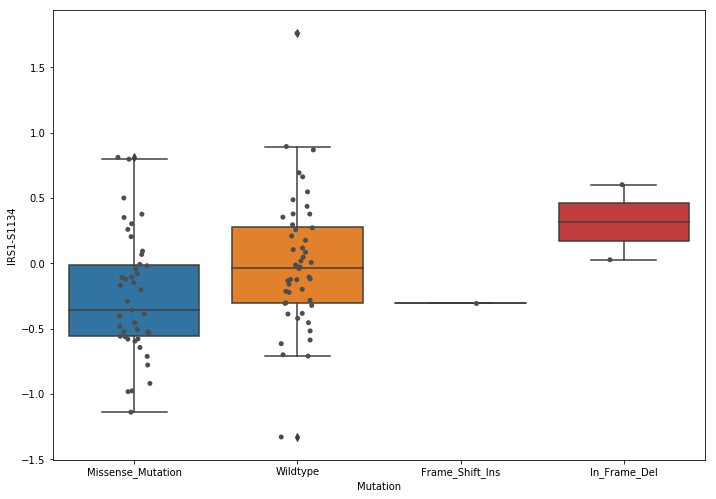

In [15]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)

boxplt = sns.boxplot(data = phosdf, x = 'Mutation', y = 'IRS1-S1134')
boxplt = sns.stripplot(data = phosdf, x = 'Mutation', y = 'IRS1-S1134', jitter = True, color = '.3')
plt.show()

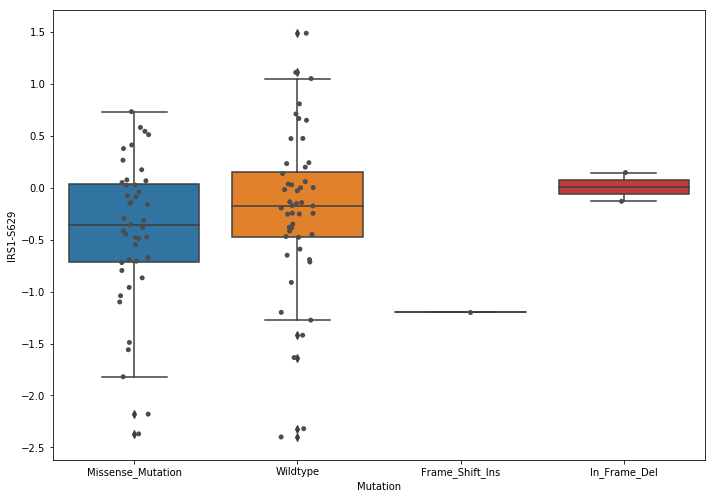

In [16]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)

boxplt = sns.boxplot(data = phosdf, x = 'Mutation', y = 'IRS1-S629')
boxplt = sns.stripplot(data = phosdf, x = 'Mutation', y = 'IRS1-S629', jitter = True, color = '.3')
plt.show()

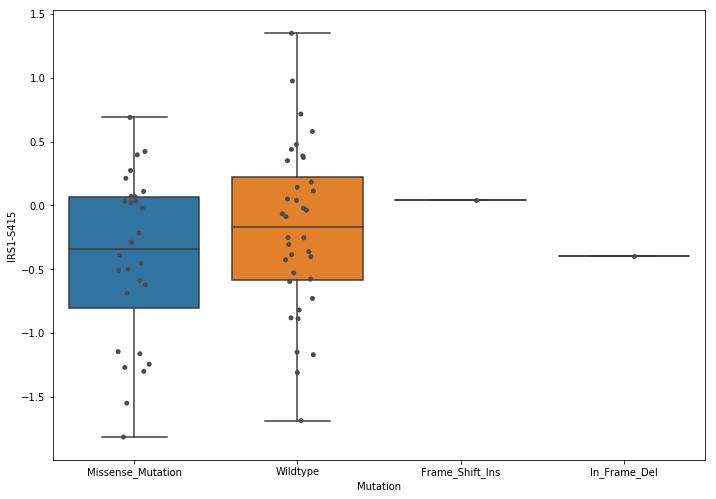

In [17]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)

boxplt = sns.boxplot(data = phosdf, x = 'Mutation', y = 'IRS1-S415')
boxplt = sns.stripplot(data = phosdf, x = 'Mutation', y = 'IRS1-S415', jitter = True, color = '.3')
plt.show()

## Plot all of the statistically significant phosphoproteomic measurements

In [18]:
protein = 'IRS1'
gene = 'PIK3CA'
phosdf = CPTAC.compare_mutations(phos, protein, gene)
phosdf = phosdf.loc[phosdf['Patient_Type'] == 'Tumor'].drop('Patient_Type', axis=1)

In [19]:
phosdf.loc[(phosdf['Mutation'] == "Wildtype"), "Mutation"] = "Control"
phosdf.loc[(phosdf['Mutation'] != "Control"), "Mutation"] = "Mutated"

phosdf = pd.melt(phosdf, id_vars=['Mutation'], var_name='Type', value_name='Reading')
phosdf = phosdf.loc[(phosdf["Mutation"] == "Control") | (phosdf["Mutation"] == "Mutated")]
phosdf = phosdf.dropna(axis=0).sort_values(by=['Mutation'], ascending=False)
#phosdf = phosdf.loc[(phosdf['Type'] == significant_sites)]


In [20]:
plotdf = None
interested_sites = ['IRS1-S1101', 'IRS1-S1133', 'IRS1-S1134', 'IRS1-S672', 'IRS1-S766']

for site in interested_sites:
    print(site)
    tempdf = phosdf.loc[(phosdf['Type'] == site)]
    print(tempdf)
    if plotdf is None:
        plotdf = tempdf
    else:
        plotdf = plotdf.append(tempdf)
        
#print(plotdf)

IRS1-S1101
    Mutation        Type  Reading
373  Mutated  IRS1-S1101 -0.58500
302  Mutated  IRS1-S1101  0.43800
369  Mutated  IRS1-S1101 -0.30100
367  Mutated  IRS1-S1101 -0.03340
308  Mutated  IRS1-S1101 -0.21900
309  Mutated  IRS1-S1101  0.15050
366  Mutated  IRS1-S1101  1.22000
300  Mutated  IRS1-S1101 -0.20400
387  Mutated  IRS1-S1101 -0.16500
385  Mutated  IRS1-S1101 -0.21800
383  Mutated  IRS1-S1101 -0.45050
380  Mutated  IRS1-S1101 -1.16000
398  Mutated  IRS1-S1101 -1.60000
397  Mutated  IRS1-S1101 -0.62850
389  Mutated  IRS1-S1101 -0.05500
388  Mutated  IRS1-S1101 -0.08150
394  Mutated  IRS1-S1101 -0.06100
395  Mutated  IRS1-S1101 -0.52100
396  Mutated  IRS1-S1101 -0.66200
376  Mutated  IRS1-S1101 -0.73400
374  Mutated  IRS1-S1101  0.02250
354  Mutated  IRS1-S1101  0.08860
332  Mutated  IRS1-S1101 -0.42100
352  Mutated  IRS1-S1101 -0.57800
325  Mutated  IRS1-S1101  0.90500
326  Mutated  IRS1-S1101 -0.57400
327  Mutated  IRS1-S1101  0.22800
365  Mutated  IRS1-S1101 -0.84100
331

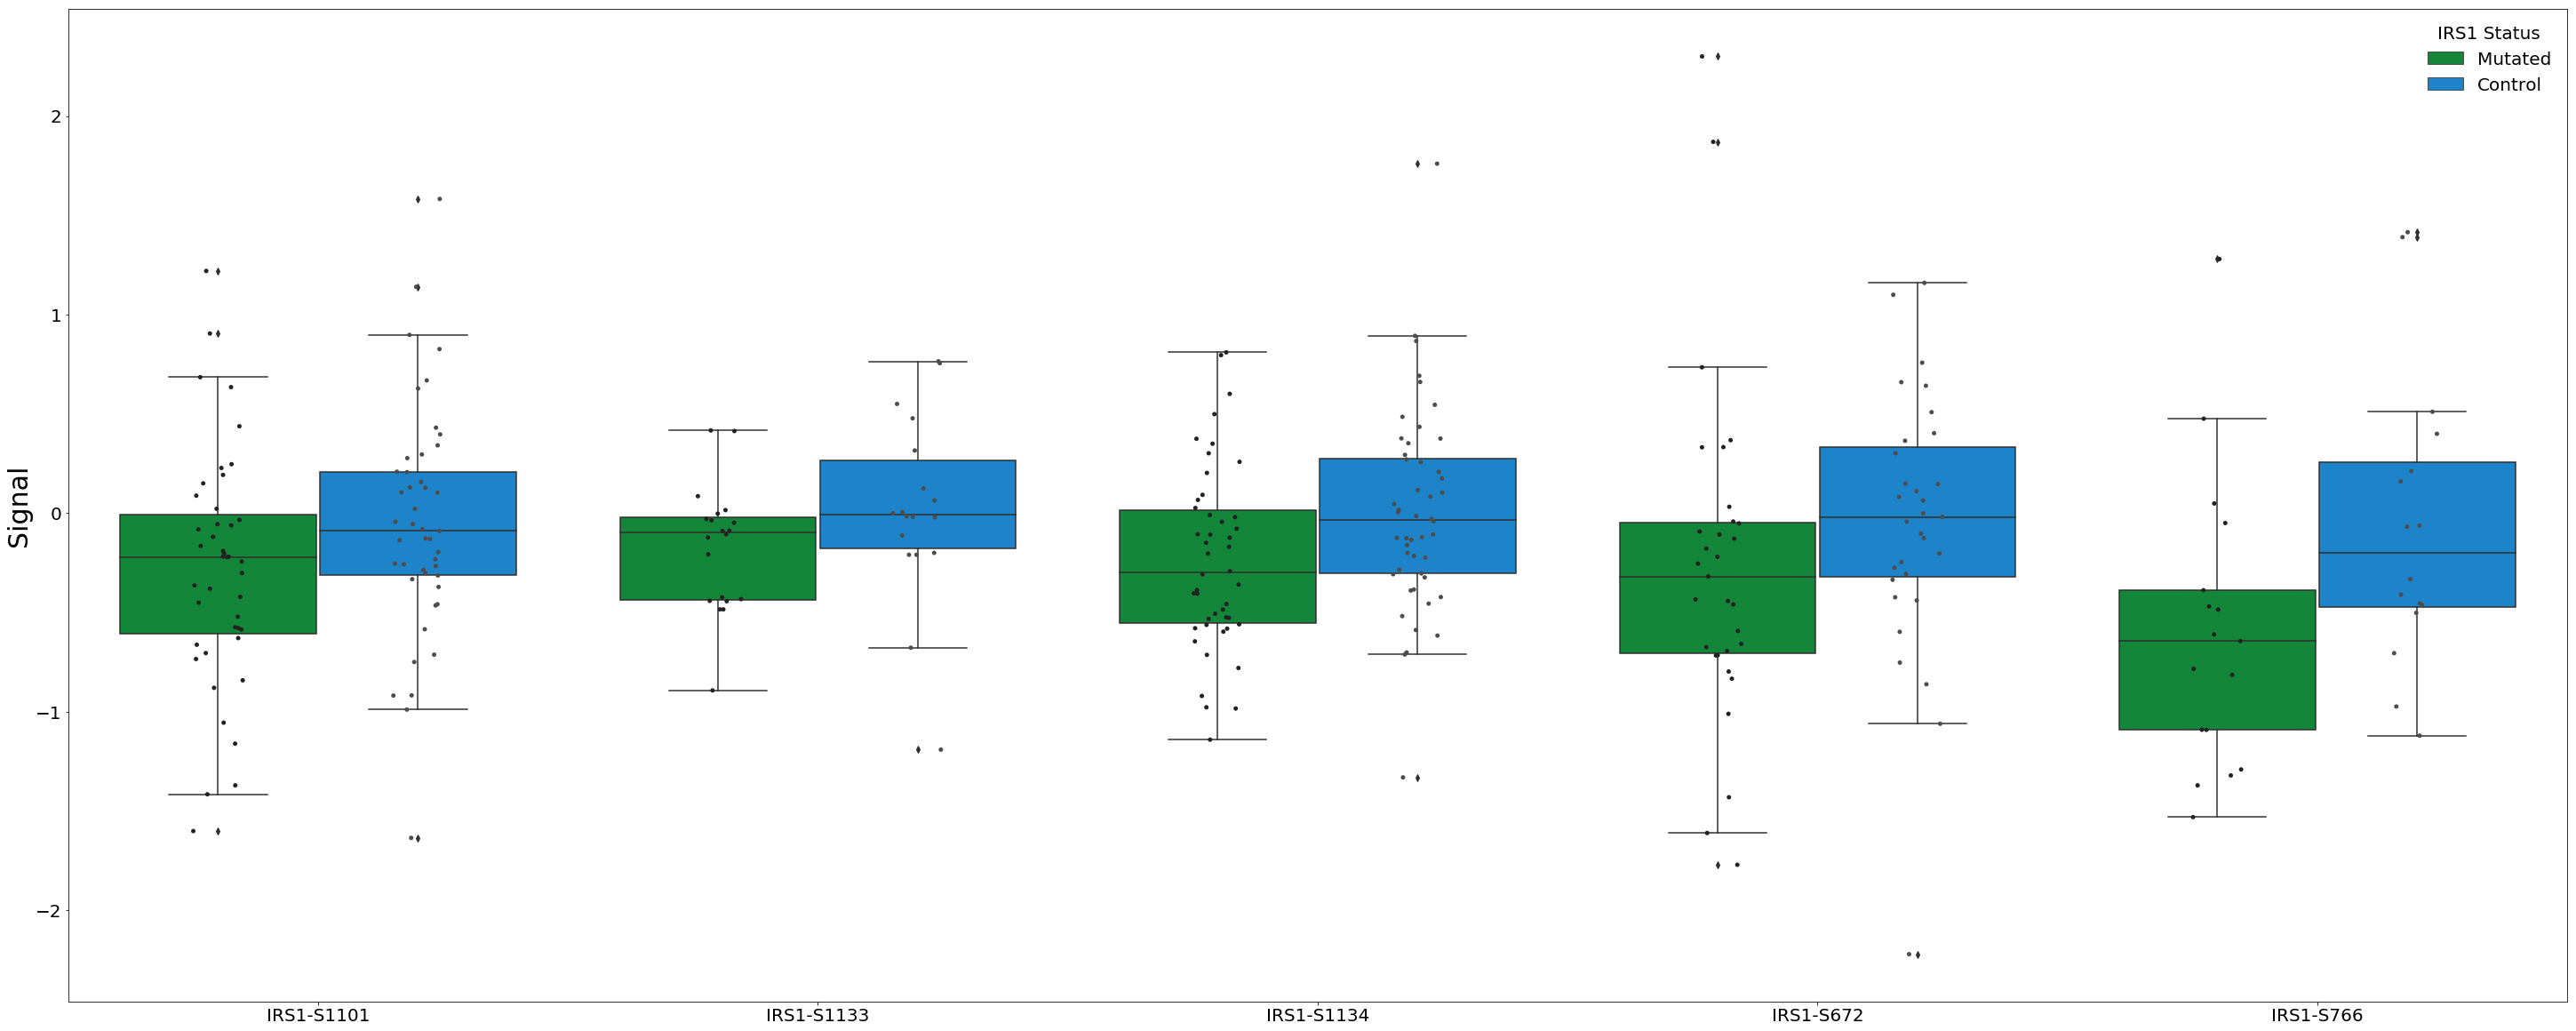

In [21]:
a4_dims = (50.4, 20.54)
fig, ax = plt.subplots(figsize=a4_dims)
my_pal = {"Mutated": "#009933", "Control": "#008ae6"}

#Create the plot
boxplt = sns.boxplot(x='Type', y='Reading', hue='Mutation', data=plotdf, palette=my_pal)
boxplt = sns.stripplot(data=plotdf, x='Type', y='Reading', hue='Mutation', dodge=True, jitter=True, color='.3')

#Add styling
boxplt.set_xlabel('')
boxplt.set_ylabel('Signal', fontsize='30')
boxplt.tick_params(labelsize='20')

#Adjust legend
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:2], ['Mutated', 'Control'], title='IRS1 Status', fontsize='20', frameon=False)
boxplt.get_legend().get_title().set_fontsize('20')
#boxplt.get_legend().set_bbox_to_anchor((1, 1, 0, 0))


fig = boxplt.get_figure()
plt.show()

<b> Note: IRS1-S1101 is phosphorylated by RPS6KB1 </b>